## Multi-label Land Cover Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai import *
from fastai.callbacks import CSVLogger, SaveModelCallback
import matplotlib.pyplot as plt
import seaborn as sns
import torch

Download the data

In [2]:
!wget https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
!unzip UCMercedLanduse.zip

--2021-11-27 17:57:16--  https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip [following]
--2021-11-27 17:57:16--  https://www.dropbox.com/s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce70dba5b566b4ef7e193f02cd5.dl.dropboxusercontent.com/cd/0/inline/BawMMuCutyXLQ_sJDSGIvFyOscQDXhXJDtZ5s-hRTByGXgtXtSTv9l1Dz7ga1DV2jOkQWXXuY-woDw69_SSegc0pb_fidGgGaxM6-48HfHDb3U_rWya3B-8xYMPUr834WVqF_zzsUTIF23IfOZL7kx3l/file# [following]
--2021-11-27 17:57:16--  https://uce70dba5b566b4ef7e193f02cd5.dl.dropboxusercontent.com/cd/0/inline/BawMMuCutyXLQ_sJDSGIvFyOscQDXhXJDtZ5s-hRTByGXgtXtSTv9l1Dz7ga1DV2jOkQW

Read Data and plot 

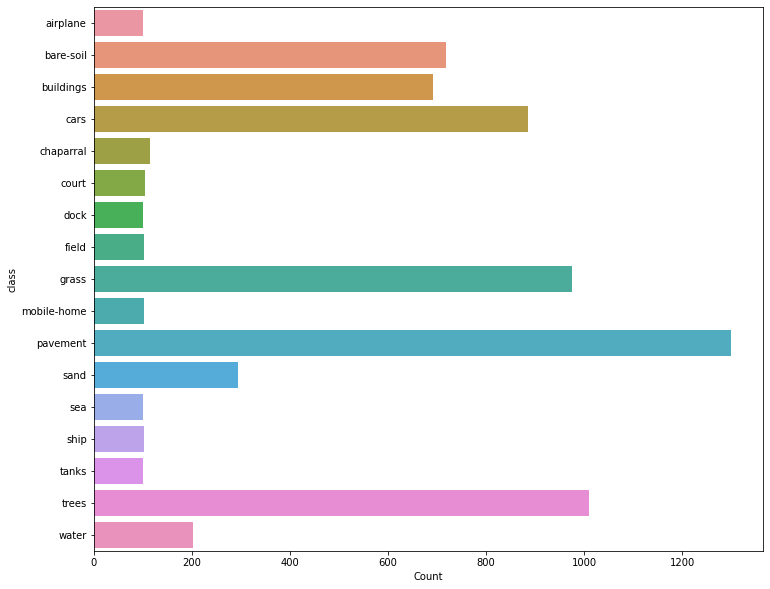

In [3]:
df = pd.read_csv("UCMerced/multilabels.txt", sep="\t")
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ["class", "Count"]
class_count.drop(class_count.index[0], inplace=True)

fig, ax= plt.subplots(figsize=(12,10))
sns.barplot(y="class", x="Count",  data=class_count, ax=ax);


Training


In [4]:
path =  Path("UCMerced")
data_src = (ImageList.from_df(df=df, path=path, folder='images', suffix=".tif")
            .split_by_rand_pct(0.2)
            
            .label_from_df(cols=list(class_count['class']), label_cls=MultiCategoryList, one_hot=True))

# data augmentation
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

# use imagenet_stats for normalization since we are using pretrained model
data = (data_src.transform(tfms, size=256).databunch().normalize(imagenet_stats))

f_score = partial(fbeta, thresh=0.45)
learn = cnn_learner(data, models.resnet34, metrics=[accuracy_thresh, f_score],
                    callback_fns=[ShowGraph, SaveModelCallback])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [5]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.749622,0.375161,0.853221,0.791237,00:20
1,0.425649,0.152926,0.938235,0.866938,00:18
2,0.274756,0.121200,0.951821,0.902384,00:18
3,0.200317,0.112653,0.950280,0.895941,00:18
4,0.156558,0.109200,0.952521,0.896297,00:18


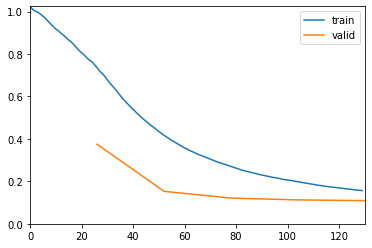

Better model found at epoch 0 with valid_loss value: 0.3751605153083801.
Better model found at epoch 1 with valid_loss value: 0.15292581915855408.
Better model found at epoch 2 with valid_loss value: 0.12120039016008377.
Better model found at epoch 3 with valid_loss value: 0.11265286058187485.
Better model found at epoch 4 with valid_loss value: 0.10919973254203796.


In [6]:
learn.fit_one_cycle(5, 1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


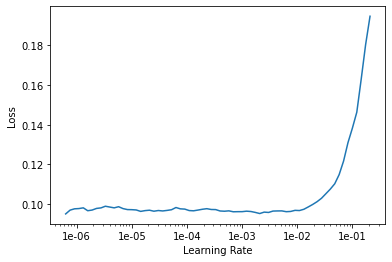

In [7]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.100042,0.106710,0.953361,0.899640,00:18
1,0.097163,0.104919,0.955882,0.909671,00:18
2,0.093655,0.102699,0.955882,0.906437,00:18
3,0.093025,0.102588,0.956022,0.909714,00:18
4,0.090167,0.102902,0.955462,0.905192,00:18


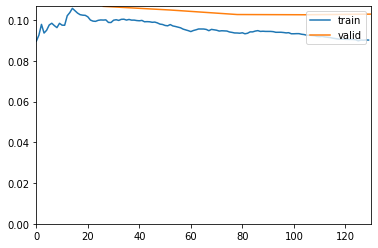

Better model found at epoch 0 with valid_loss value: 0.10670952498912811.
Better model found at epoch 1 with valid_loss value: 0.10491936653852463.
Better model found at epoch 2 with valid_loss value: 0.10269907861948013.
Better model found at epoch 3 with valid_loss value: 0.1025879979133606.


In [8]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

Testing


In [9]:
!wget https://www.dropbox.com/s/6tt0t61uq2w1n3s/test.zip
!unzip test.zip

--2021-11-27 18:09:48--  https://www.dropbox.com/s/6tt0t61uq2w1n3s/test.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6tt0t61uq2w1n3s/test.zip [following]
--2021-11-27 18:09:48--  https://www.dropbox.com/s/raw/6tt0t61uq2w1n3s/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44fe059f37fc6ac17588f665fc.dl.dropboxusercontent.com/cd/0/inline/Bay0DAIQNO1yBQqceanZGLjmygRsRJ0Ier6s3ZzkuBNOXrijDYhS2jyPw7kvRU0KNibASn7WgRU1vW-yXXat4_GMTvsyFETTGusTY45-bLacvemIMFtkMKQG3qs-iMH0IHCcwmePwtmpCKinNwPzU8th/file# [following]
--2021-11-27 18:09:48--  https://uc44fe059f37fc6ac17588f665fc.dl.dropboxusercontent.com/cd/0/inline/Bay0DAIQNO1yBQqceanZGLjmygRsRJ0Ier6s3ZzkuBNOXrijDYhS2jyPw7kvRU0KNibASn7WgRU1vW-yXXat4_GMTvsyFETTGusTY4

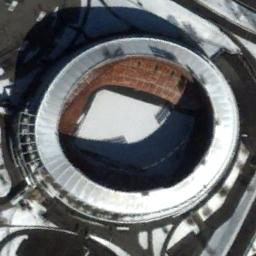

In [11]:
img = open_image("/content/test/stadium_040.jpg")
img

In [13]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)

bare-soil;pavement;tanks


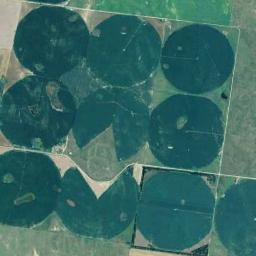

In [14]:
img = open_image("/content/test/circular_farmland_006.jpg")
img

In [15]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)

grass;pavement
